# Implementación de algoritmo de Dijkstra

referencia: [PythonRobotics](https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/Dijkstra/dijkstra.py)

In [1]:
import matplotlib.pyplot as plt
import math

class Dijkstra:

    def __init__(self, ox, oy, reso, rr):
        """
        Initialize map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        reso: grid resolution [m]
        rr: robot radius[m]
        """

        self.reso = reso
        self.rr = rr
        self.calc_obstacle_map(ox, oy)
        self.motion = self.get_motion_model()

    class Node:
        def __init__(self, x, y, cost, pind):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.pind = pind # index of previous Node

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.pind)

    def planning(self, sx, sy, gx, gy):
        """
        dijkstra path search

        input:
            sx: start x position [m]
            sy: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        nstart = self.Node(self.calc_xyindex(sx, self.minx),
                           self.calc_xyindex(sy, self.miny), 0.0, -1)
        ngoal = self.Node(self.calc_xyindex(gx, self.minx),
                          self.calc_xyindex(gy, self.miny), 0.0, -1)

        openset, closedset = dict(), dict()
        openset[self.calc_index(nstart)] = nstart

        while 1:
            c_id = min(openset, key=lambda o: openset[o].cost)
            current = openset[c_id]

            if current.x == ngoal.x and current.y == ngoal.y:
                print("Find goal")
                ngoal.pind = current.pind
                ngoal.cost = current.cost
                break

            # Remove the item from the open set
            del openset[c_id]

            # Add it to the closed set
            closedset[c_id] = current

            # expand search grid based on motion model
            for move_x, move_y, move_cost in self.motion:
                node = self.Node(current.x + move_x,
                                 current.y + move_y,
                                 current.cost + move_cost, c_id)
                n_id = self.calc_index(node)

                if n_id in closedset:
                    continue

                if not self.verify_node(node):
                    continue

                if n_id not in openset:
                    openset[n_id] = node  # Discover a new node
                else:
                    if openset[n_id].cost >= node.cost:
                        # This path is the best until now. record it!
                        openset[n_id] = node

        rx, ry = self.calc_final_path(ngoal, closedset)

        return rx, ry

    def calc_final_path(self, ngoal, closedset):
        # generate final course
        rx, ry = [self.calc_position(ngoal.x, self.minx)], [
            self.calc_position(ngoal.y, self.miny)]
        pind = ngoal.pind
        while pind != -1:
            n = closedset[pind]
            rx.append(self.calc_position(n.x, self.minx))
            ry.append(self.calc_position(n.y, self.miny))
            pind = n.pind

        return rx, ry

    def calc_position(self, index, minp):
        pos = index*self.reso+minp
        return pos

    def calc_xyindex(self, position, minp):
        return round((position - minp)/self.reso)

    def calc_index(self, node):
        return (node.y - self.miny) * self.xwidth + (node.x - self.minx)

    def verify_node(self, node):
        px = self.calc_position(node.x, self.minx)
        py = self.calc_position(node.y, self.miny)

        if px < self.minx:
            return False
        elif py < self.miny:
            return False
        elif px >= self.maxx:
            return False
        elif py >= self.maxy:
            return False

        if self.obmap[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.minx = round(min(ox))
        self.miny = round(min(oy))
        self.maxx = round(max(ox))
        self.maxy = round(max(oy))
        print("minx:", self.minx)
        print("miny:", self.miny)
        print("maxx:", self.maxx)
        print("maxy:", self.maxy)

        self.xwidth = round((self.maxx - self.minx)/self.reso)
        self.ywidth = round((self.maxy - self.miny)/self.reso)
        print("xwidth:", self.xwidth)
        print("ywidth:", self.ywidth)

        # obstacle map generation
        self.obmap = [[False for i in range(self.ywidth)]
                      for i in range(self.xwidth)]
        for ix in range(self.xwidth):
            x = self.calc_position(ix, self.minx)
            for iy in range(self.ywidth):
                y = self.calc_position(iy, self.miny)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obmap[ix][iy] = True
                        break

    def get_motion_model(self):
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion

## Función de ayuda para correr el algoritmo Dijkstra

* (sx, sy) es el punto de inicio
* (gx, gy) punto destino
* grid_size es el tamaño del grid en metros (2 metros por defecto)

In [2]:
def find(sx, sy, gx, gy, grid_size=2):
    robot_radius=1
    # set obstacle positions
    ox, oy = [], []
    for i in range(-10, 60):
        ox.append(i)
        oy.append(-10.0)
    for i in range(-10, 60):
        ox.append(60.0)
        oy.append(i)
    for i in range(-10, 61):
        ox.append(i)
        oy.append(60.0)
    for i in range(-10, 61):
        ox.append(-10.0)
        oy.append(i)
    for i in range(-10, 40):
        ox.append(20.0)
        oy.append(i)
    for i in range(0, 40):
        ox.append(40.0)
        oy.append(60.0 - i)

    plt.plot(ox, oy, ".k")
    plt.plot(sx, sy, "og")
    plt.plot(gx, gy, "xb")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

    dijkstra = Dijkstra(ox, oy, grid_size, robot_radius)
    rx, ry = dijkstra.planning(sx, sy, gx, gy)

    plt.plot(ox, oy, ".k")
    plt.plot(sx, sy, "og")
    plt.plot(gx, gy, "xb")
    plt.plot(rx, ry, "-r")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

## Probando el algoritmo

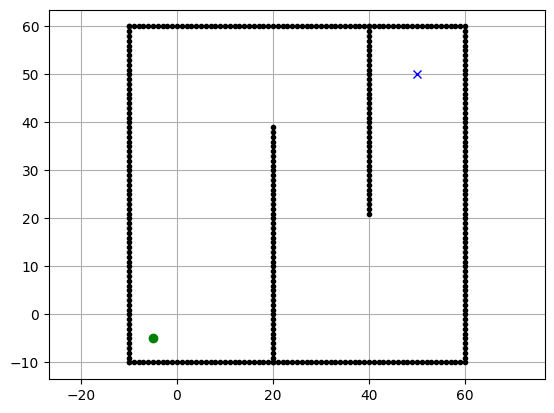

minx: -10
miny: -10
maxx: 60
maxy: 60
xwidth: 35
ywidth: 35
Find goal


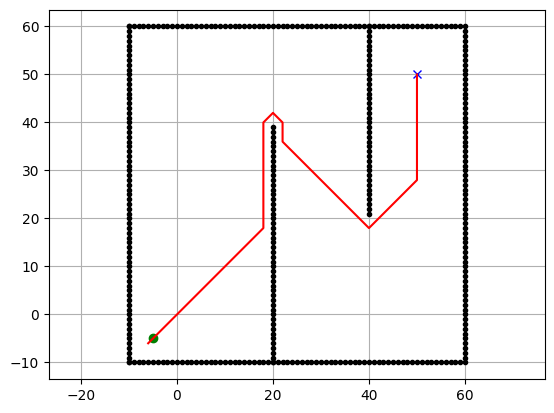

In [4]:
sx = -5.0  # valor de inicio en x [m]
sy = -5.0  # valor de inicio en y [m]
gx = 50.0  # valor de destino en x [m]
gy = 50.0  # valor de destino en y [m]

find(sx, sy, gx, gy)